In [16]:
import os
import time
import numpy as np
import random
import torch
from tqdm import tqdm

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
data_root = os.path.join(os.getcwd(), '../idao_dataset/train')
print(data_root)

/home/sovadim/workspace/idao2021robosapiens/track_1/../idao_dataset/train


In [5]:
classes = {
    'particle': [
        'ER',
        'NR'
    ],
    'energy': [
        '1',
        '3',
        '6',
        '10',
        '20',
        '30'
    ]
}

In [6]:
train_dir = os.path.join(os.getcwd(), '..', 'tmp', 'train')
val_dir = os.path.join(os.getcwd(), '..', 'tmp', 'val')

In [7]:
import torchvision
from torchvision import transforms, models
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

In [9]:
batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [10]:
len(train_dataloader), len(train_dataset)

(1397, 11169)

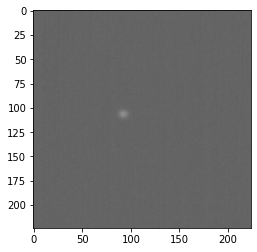

In [11]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

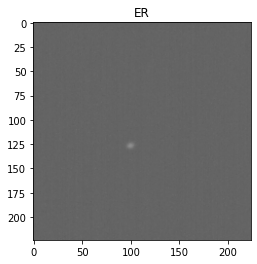

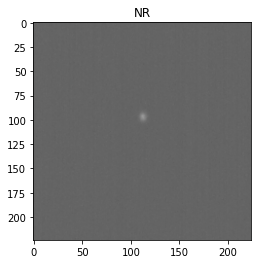

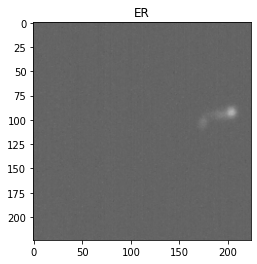

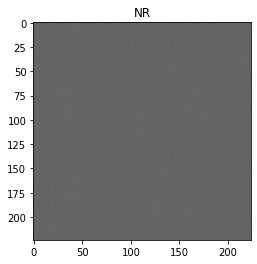

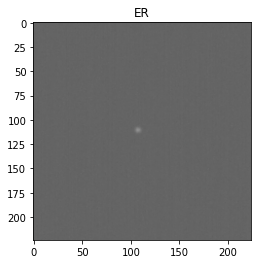

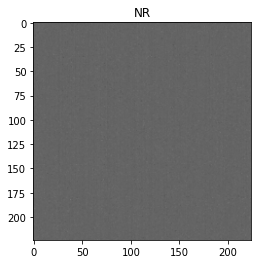

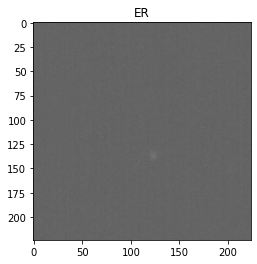

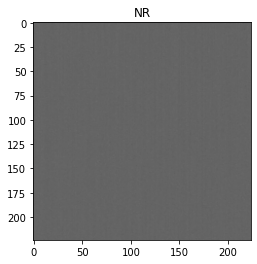

In [12]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=classes['particle'][y_item])

In [13]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [14]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
train_model(model, loss, optimizer, scheduler, num_epochs=10)

Epoch 0/9:


100%|██████████| 1397/1397 [00:29<00:00, 46.86it/s]

train Loss: 0.6499 Acc: 0.6211



 24%|██▍       | 67/280 [00:01<00:04, 49.84it/s]

In [ ]:
# parse photos:
# 

In [ ]:
# verify data correctness

In [ ]:
# TODO: denoising

In [ ]:
# TODO: augmentation

In [ ]:
# TODO: model

In [ ]:
# TODO: setup loss-function

In [ ]:
# TODO: optimizer

In [ ]:
# TODO: setup epochs

In [ ]:
# TODO: Quality metric: (AUC - MAE) * 1000

In [ ]:
"""TODO: upload your predictions into the system in the .csv format. The ﬁle should consist of 16564 rows and contain three columns:
id, classiﬁcation_predictions, regression_predictions"""

In [ ]:
# TODO: build csv solution